In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import explained_variance_score
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

%matplotlib inline

#### Loading data created by psql and some exploration

In [2]:
df = pd.read_csv('data/bowling_data_enhanced.csv')
df.shape

(4742, 30)

In [3]:
df.head()

,overs,mdns,runs,wkts,econ,ave,strike_rate,opposition,ground,home_away,...,year5_mtchs_pld,year1_wkts_pm,year2_wkts_pm,year3_wkts_pm,year4_wkts_pm,year5_wkts_pm,bowler_agnst_oppo,oppo_agnst_bowl_typ,bowl_home_adv,ground_bowl_typ
0,32.0,6,105,6,3.28,17.50,32.0,West Indies,Manchester,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,34.0,5,108,4,3.17,27.00,51.0,New Zealand,Nottingham,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,10.0,4,25,3,2.50,8.33,20.0,West Indies,Lord's,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,37.5,12,103,3,2.72,34.33,75.6,New Zealand,Lord's,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15.0,1,52,2,3.46,26.00,45.0,West Indies,Birmingham,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
df.columns

Index(['overs', 'mdns', 'runs', 'wkts', 'econ', 'ave', 'strike_rate',
       'opposition', 'ground', 'home_away', 'bowling_arm', 'pace_spin',
       'player', 'country', 'year', 'balls', 'year1_mtchs_pld',
       'year2_mtchs_pld', 'year3_mtchs_pld', 'year4_mtchs_pld',
       'year5_mtchs_pld', 'year1_wkts_pm', 'year2_wkts_pm', 'year3_wkts_pm',
       'year4_wkts_pm', 'year5_wkts_pm', 'bowler_agnst_oppo',
       'oppo_agnst_bowl_typ', 'bowl_home_adv', 'ground_bowl_typ'],
      dtype='object')

In [5]:
mask_2005_2011 = (df.year >= 2005) & (df.year <= 2011)

In [6]:
mask_2005_2011.value_counts()

False    2966
True     1776
Name: year, dtype: int64

In [7]:
len(mask_2005_2011), type(mask_2005_2011)

(4742, pandas.core.series.Series)

In [8]:
df_2005_2011 = df[mask_2005_2011]
df_2005_2011.shape

(1776, 30)

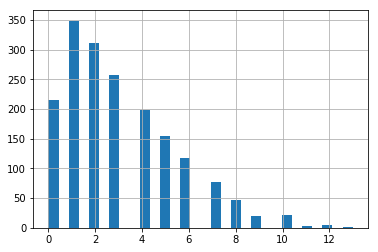

In [9]:
df_2005_2011.wkts.hist(bins=30)
plt.show()

In [10]:
df_2005_2011_small = df_2005_2011[['wkts','year1_mtchs_pld',
       'year1_wkts_pm', 'bowler_agnst_oppo',
       'oppo_agnst_bowl_typ', 'bowl_home_adv', 'ground_bowl_typ']]

In [12]:
df_2005_2011_small.head(10)

,wkts,year1_mtchs_pld,year1_wkts_pm,bowler_agnst_oppo,oppo_agnst_bowl_typ,bowl_home_adv,ground_bowl_typ
273,0,4.0,1.25,1.000000,1.477124,0.375000,1.309524
274,2,3.0,2.00,1.003472,1.159041,0.521739,1.309524
275,7,10.0,5.80,1.000000,1.159041,0.407855,1.309524
276,3,8.0,2.25,1.000000,0.840114,0.282051,0.864583
277,1,2.0,0.50,1.000000,0.840114,0.500000,0.864583
278,6,4.0,4.00,1.000000,0.840114,0.500000,0.864583
279,1,0.0,0.00,1.000000,0.840114,0.500000,0.864583
280,2,8.0,1.00,1.000000,0.840114,0.418605,0.864583
281,7,1.0,4.00,1.209877,0.967320,0.564815,0.864583
282,3,8.0,3.75,0.697674,0.967320,0.476744,0.864583


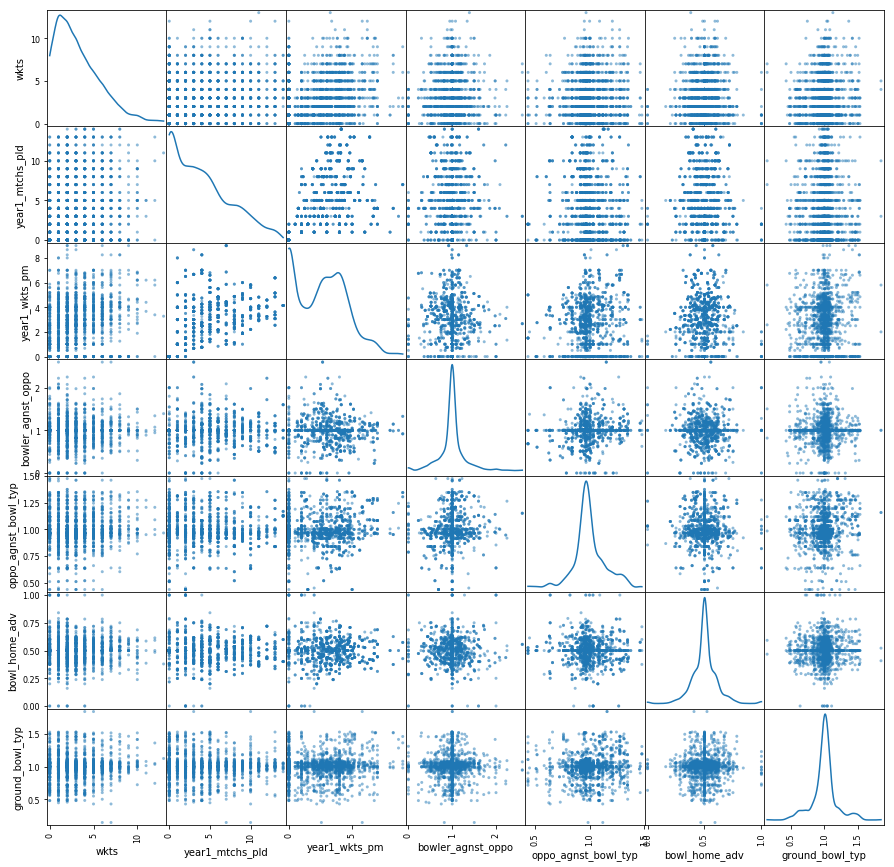

In [13]:
scatter_matrix(df_2005_2011_small, figsize=(15,15), diagonal='kde')
plt.show()

#### Training with 2005-2010 data and testing on 2011

In [14]:
features = ['year1_mtchs_pld',
       'year2_mtchs_pld', 'year3_mtchs_pld', 'year4_mtchs_pld',
       'year5_mtchs_pld', 'year1_wkts_pm', 'year2_wkts_pm', 'year3_wkts_pm',
       'year4_wkts_pm', 'year5_wkts_pm', 'bowler_agnst_oppo',
       'oppo_agnst_bowl_typ', 'bowl_home_adv', 'ground_bowl_typ']
target = 'wkts'

In [15]:
mask_2005_2010 = (df.year >= 2005) & (df.year <= 2010)
mask_2011 = (df.year == 2011)

In [16]:
len(mask_2005_2010), type(mask_2005_2010), len(mask_2011), type(mask_2011)

(4742, pandas.core.series.Series, 4742, pandas.core.series.Series)

In [17]:
mask_2005_2010.value_counts()

False    3185
True     1557
Name: year, dtype: int64

In [18]:
X_train = df[mask_2005_2010][features]
X_test = df[mask_2011][features]
y_train = df[mask_2005_2010][target]
y_test = df[mask_2011][target]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1557, 14), (219, 14), (1557,), (219,))

In [19]:
rf = RandomForestRegressor(n_estimators=100,max_features=5,n_jobs=-1,random_state=10)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_test)

In [20]:
print("R^2 Score Train: ", rf.score(X_train, y_train))

R^2 Score Train:  0.845022506832


In [21]:
print("R^2 Score Test: ", rf.score(X_test, y_test))

R^2 Score Test:  -0.0837703679769


In [22]:
feature_importance = {}
for label, importance in zip(X_train.columns, rf.feature_importances_):
    feature_importance[label] = importance

#feature_importance
sorted(feature_importance.items(), key=lambda x: (-x[1]))

[('ground_bowl_typ', 0.31987757109102249),
 ('oppo_agnst_bowl_typ', 0.14528584703308775),
 ('year1_wkts_pm', 0.10026538901589331),
 ('bowl_home_adv', 0.067027140329687332),
 ('bowler_agnst_oppo', 0.059101650292704713),
 ('year3_wkts_pm', 0.053127243171482832),
 ('year2_wkts_pm', 0.049040735443305242),
 ('year4_wkts_pm', 0.044540844331590786),
 ('year1_mtchs_pld', 0.041003218081099461),
 ('year2_mtchs_pld', 0.02873168296544331),
 ('year5_wkts_pm', 0.026965273373650307),
 ('year4_mtchs_pld', 0.02226124689010886),
 ('year3_mtchs_pld', 0.021872778352886247),
 ('year5_mtchs_pld', 0.020899379628037382)]

[ 0.31987757  0.14528585  0.10026539  0.06702714  0.05910165  0.05312724
  0.04904074  0.04454084  0.04100322  0.02873168  0.02696527  0.02226125
  0.02187278  0.02089938]


(-1, 14)

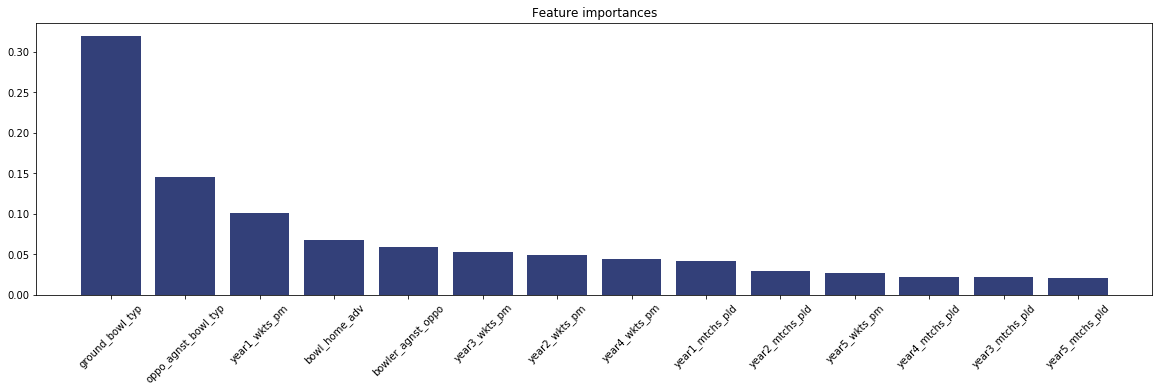

In [23]:
importances = rf.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = list(X_train.columns[indices])
print (importances[indices])
plt.figure(figsize=(20,5))
plt.title("Feature importances")
plt.bar(range(14), importances[indices], color="#334079", align="center")
# #664079
plt.xticks(range(14), feature_names,rotation='45')
plt.xlim([-1, 14])

In [24]:
random_forest_grid = {'max_depth': [3, None],
                      'max_features': ['sqrt', 'log2', 5, None],
                      'min_samples_split': [2, 4],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [100,300,500],
                      'random_state': [10]}

rf_gridsearch = GridSearchCV(RandomForestRegressor(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='r2')
rf_gridsearch.fit(X_train, y_train)

print("best parameters:", rf_gridsearch.best_params_)

best_rf_model = rf_gridsearch.best_estimator_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    9.2s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:   40.0s
[Parallel(n_jobs=-1)]: Done 506 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 856 tasks      | elapsed:  3.5min


best parameters: {'bootstrap': True, 'max_depth': 3, 'max_features': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 10}


[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  3.6min finished


In [25]:
rf_gridsearch.best_score_

0.067828001630825738

In [26]:
rf_gridsearch.score(X_train,y_train)

0.15887258698607898

In [27]:
rf_gridsearch.score(X_test,y_test)

-0.022167316162469586

In [28]:
best_rf_model.score(X_test,y_test)

-0.022167316162469586

In [29]:
feature_importance = {}
for label, importance in zip(X_train.columns, best_rf_model.feature_importances_):
    feature_importance[label] = importance

#feature_importance
sorted(feature_importance.items(), key=lambda x: (-x[1]))

[('year1_wkts_pm', 0.3449863591221019),
 ('year4_wkts_pm', 0.17194511058217363),
 ('year3_wkts_pm', 0.13783850464054984),
 ('year2_wkts_pm', 0.10211723260571721),
 ('ground_bowl_typ', 0.038404915486087654),
 ('year5_wkts_pm', 0.037840587479928259),
 ('year1_mtchs_pld', 0.037623923665338982),
 ('bowl_home_adv', 0.026068425551716692),
 ('oppo_agnst_bowl_typ', 0.022754612060818347),
 ('bowler_agnst_oppo', 0.020974925564761975),
 ('year5_mtchs_pld', 0.020754004140177675),
 ('year4_mtchs_pld', 0.015433864635704403),
 ('year2_mtchs_pld', 0.012056425299555092),
 ('year3_mtchs_pld', 0.01120110916536831)]

[ 0.34498636  0.17194511  0.1378385   0.10211723  0.03840492  0.03784059
  0.03762392  0.02606843  0.02275461  0.02097493  0.020754    0.01543386
  0.01205643  0.01120111]


(-1, 14)

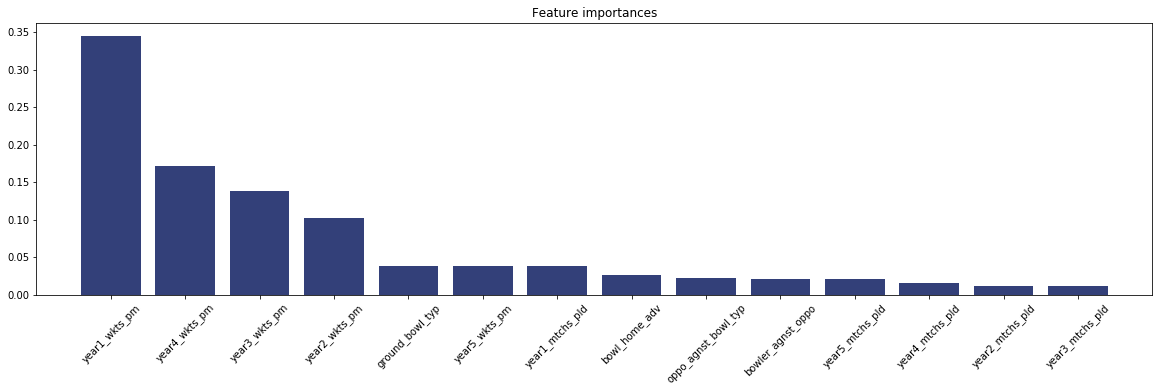

In [30]:
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = list(X_train.columns[indices])
print (importances[indices])
plt.figure(figsize=(20,5))
plt.title("Feature importances")
plt.bar(range(14), importances[indices], color="#334079", align="center")
# #664079
plt.xticks(range(14), feature_names,rotation='45')
plt.xlim([-1, 14])

In [31]:
features_small = ['year1_wkts_pm','year2_wkts_pm', 'year3_wkts_pm', 'year4_wkts_pm','year5_wkts_pm',
                  'bowler_agnst_oppo','oppo_agnst_bowl_typ', 'bowl_home_adv', 'ground_bowl_typ']

In [32]:
X_train = df[mask_2005_2010][features_small]
X_test = df[mask_2011][features_small]
y_train = df[mask_2005_2010][target]
y_test = df[mask_2011][target]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1557, 9), (219, 9), (1557,), (219,))

In [33]:
random_forest_grid = {'max_depth': [3, None],
                      'max_features': ['sqrt', 'log2', 5, None],
                      'min_samples_split': [2, 4],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [100,300,500],
                      'random_state': [10]}

rf_gridsearch = GridSearchCV(RandomForestRegressor(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='r2')
rf_gridsearch.fit(X_train, y_train)

print("best parameters:", rf_gridsearch.best_params_)

best_rf_model = rf_gridsearch.best_estimator_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 229 tasks      | elapsed:   33.4s
[Parallel(n_jobs=-1)]: Done 479 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 829 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  3.6min finished


best parameters: {'bootstrap': True, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 4, 'n_estimators': 100, 'random_state': 10}


In [34]:
best_rf_model.score(X_train,y_train), best_rf_model.score(X_test,y_test), 

(0.15483495491014942, -0.013513787519671361)

In [35]:
feature_importance = {}
for label, importance in zip(X_train.columns, best_rf_model.feature_importances_):
    feature_importance[label] = importance

#feature_importance
sorted(feature_importance.items(), key=lambda x: (-x[1]))

[('year1_wkts_pm', 0.3444853946521062),
 ('year3_wkts_pm', 0.18777579843916481),
 ('year4_wkts_pm', 0.14066801912776553),
 ('year2_wkts_pm', 0.11880049070459016),
 ('year5_wkts_pm', 0.083527226643849872),
 ('bowl_home_adv', 0.04071466478471631),
 ('ground_bowl_typ', 0.038715865208038838),
 ('oppo_agnst_bowl_typ', 0.024243361056361303),
 ('bowler_agnst_oppo', 0.02106917938340705)]

[ 0.34448539  0.1877758   0.14066802  0.11880049  0.08352723  0.04071466
  0.03871587  0.02424336  0.02106918]


(-1, 10)

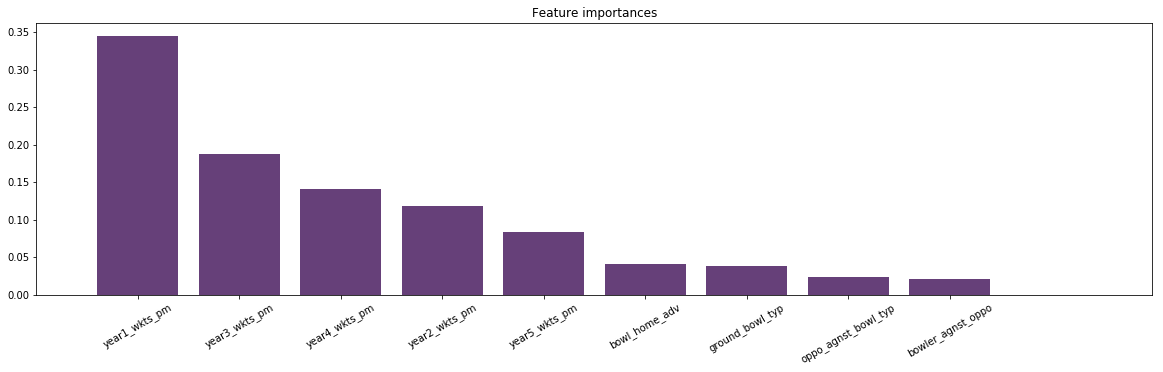

In [36]:
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = list(X_train.columns[indices])
print (importances[indices])
plt.figure(figsize=(20,5))
plt.title("Feature importances")
plt.bar(range(9), importances[indices], color="#664079", align="center")
# #664079
plt.xticks(range(9), feature_names,rotation='30')
plt.xlim([-1, 10])

In [37]:
y_test_pred = best_rf_model.predict(X_test)
type(y_test_pred)

numpy.ndarray

In [38]:
type(pd.DataFrame(y_test_pred)), pd.DataFrame(y_test_pred).shape

(pandas.core.frame.DataFrame, (219, 1))

In [39]:
type(df[mask_2011][['player','wkts']]), df[mask_2011][['player','wkts']].shape

(pandas.core.frame.DataFrame, (219, 2))

In [40]:
bowling_2011 = pd.concat([df[mask_2011][['player','wkts']].reset_index(),pd.DataFrame(y_test_pred)],axis=1,)

In [41]:
type(bowling_2011), bowling_2011.shape

(pandas.core.frame.DataFrame, (219, 4))

In [42]:
bowling_2011.head()

,index,player,wkts,0
0,2928,SK Raina,1,2.316647
1,2929,A Mishra,3,3.191171
2,2930,GP Swann,2,3.520076
3,2931,I Sharma,1,2.361441
4,2932,P Kumar,2,2.457975


In [43]:
bowling_2011 = bowling_2011.drop('index',axis=1)
bowling_2011.columns = ['player','wkts','wkts_exp']
bowling_2011.head(20)

,player,wkts,wkts_exp
0,SK Raina,1,2.316647
1,A Mishra,3,3.191171
2,GP Swann,2,3.520076
3,I Sharma,1,2.361441
4,P Kumar,2,2.457975
5,S Sreesanth,0,2.627223
6,SCJ Broad,6,2.355512
7,JM Anderson,6,4.147461
8,TT Bresnan,5,3.283985
9,D Bishoo,3,2.416721


In [44]:
bowling_2011_by_player = bowling_2011.groupby('player').sum()
bowling_2011_by_player.shape

(65, 2)

In [50]:
bowling_2011_by_player.head(10)

,wkts,wkts_exp
player,,
A Mishra,7,9.426990
A Mithun,3,2.370900
BAW Mendis,1,3.511346
BW Hilfenhaus,10,4.783549
CRD Fernando,7,10.310428
CS Martin,7,5.003677
CT Tremlett,22,16.503676
D Bishoo,19,14.448150
DAJ Bracewell,10,4.909718


In [51]:
r2_score(bowling_2011_by_player.wkts,bowling_2011_by_player.wkts_exp)

0.66711798537921307

In [52]:
explained_variance_score(bowling_2011_by_player.wkts,bowling_2011_by_player.wkts_exp)

0.69775791934581388

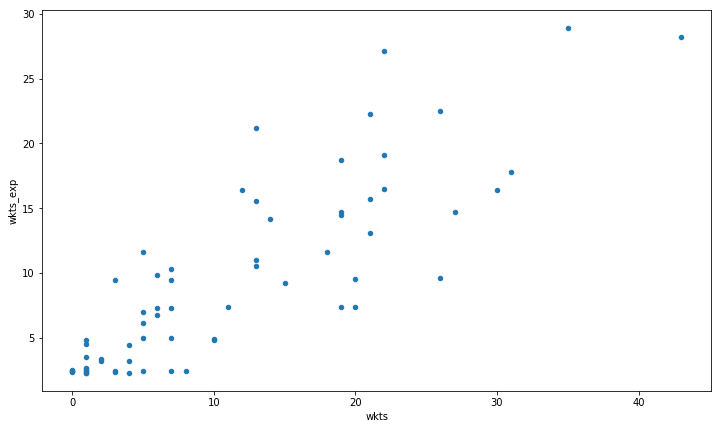

In [53]:
bowling_2011_by_player.plot(kind='scatter',x='wkts',y='wkts_exp',figsize=(12,7))
plt.show()

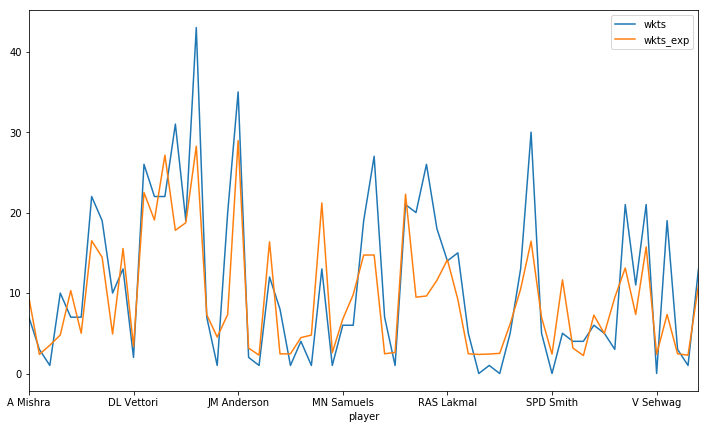

In [54]:
bowling_2011_by_player.plot(figsize=(12,7))
plt.show()

In [55]:
features_smaller = ['year1_wkts_pm','year2_wkts_pm', 'year3_wkts_pm', 'year4_wkts_pm','year5_wkts_pm',
                    'bowl_home_adv', 'ground_bowl_typ']

In [56]:
X_train = df[mask_2005_2010][features_smaller]
X_test = df[mask_2011][features_smaller]
y_train = df[mask_2005_2010][target]
y_test = df[mask_2011][target]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1557, 7), (219, 7), (1557,), (219,))

In [59]:
random_forest_grid = {'max_depth': [3, None],
                      'max_features': ['sqrt', 'log2', 3, None],
                      'min_samples_split': [2, 4],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [100,300,500],
                      'random_state': [10]}

In [60]:
rf_gridsearch = GridSearchCV(RandomForestRegressor(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='r2')
rf_gridsearch.fit(X_train, y_train)

print("best parameters:", rf_gridsearch.best_params_)

best_rf_model = rf_gridsearch.best_estimator_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 278 tasks      | elapsed:   39.9s
[Parallel(n_jobs=-1)]: Done 528 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  2.9min finished


best parameters: {'bootstrap': True, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 10}


In [61]:
best_rf_model.score(X_train,y_train), best_rf_model.score(X_test,y_test)

(0.14978212185220641, -0.012133042873580857)

In [62]:
feature_importance = {}
for label, importance in zip(X_train.columns, best_rf_model.feature_importances_):
    feature_importance[label] = importance

#feature_importance
sorted(feature_importance.items(), key=lambda x: (-x[1]))

[('year1_wkts_pm', 0.28365359092930309),
 ('year4_wkts_pm', 0.20348324192848896),
 ('year3_wkts_pm', 0.165396383852976),
 ('year2_wkts_pm', 0.15420258413078111),
 ('year5_wkts_pm', 0.10689583593833406),
 ('bowl_home_adv', 0.049710166715700783),
 ('ground_bowl_typ', 0.036658196504415909)]

[ 0.28365359  0.20348324  0.16539638  0.15420258  0.10689584  0.04971017
  0.0366582 ]


(-1, 7)

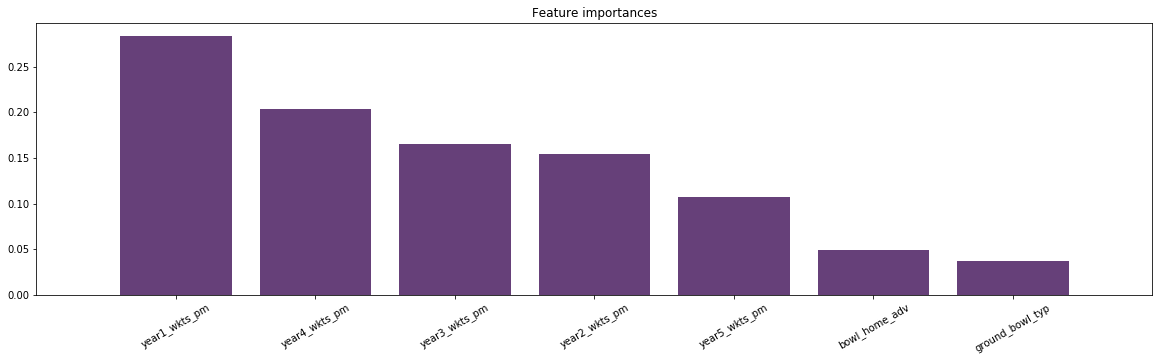

In [64]:
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = list(X_train.columns[indices])
print (importances[indices])
plt.figure(figsize=(20,5))
plt.title("Feature importances")
plt.bar(range(7), importances[indices], color="#664079", align="center")
# #664079
plt.xticks(range(7), feature_names,rotation='30')
plt.xlim([-1, 7])

In [65]:
y_test_pred = best_rf_model.predict(X_test)
type(y_test_pred), type(pd.DataFrame(y_test_pred)), pd.DataFrame(y_test_pred).shape

(numpy.ndarray, pandas.core.frame.DataFrame, (219, 1))

In [84]:
bowling_2011 = pd.concat([df[mask_2011][['player','wkts','year1_wkts_pm']].reset_index(),pd.DataFrame(y_test_pred)],axis=1,)
bowling_2011.head()

,index,player,wkts,year1_wkts_pm,0
0,2928,SK Raina,1,1.500000,2.369747
1,2929,A Mishra,3,2.666667,3.063983
2,2930,GP Swann,2,3.333333,3.194089
3,2931,I Sharma,1,1.888889,2.425694
4,2932,P Kumar,2,0.000000,2.465906


In [85]:
bowling_2011 = bowling_2011.drop('index',axis=1)
bowling_2011.columns = ['player','wkts','year1_wkts_pm','wkts_exp']
bowling_2011.head(10)

,player,wkts,year1_wkts_pm,wkts_exp
0,SK Raina,1,1.500000,2.369747
1,A Mishra,3,2.666667,3.063983
2,GP Swann,2,3.333333,3.194089
3,I Sharma,1,1.888889,2.425694
4,P Kumar,2,0.000000,2.465906
5,S Sreesanth,0,2.166667,2.752213
6,SCJ Broad,6,1.250000,2.446716
7,JM Anderson,6,4.166667,4.167213
8,TT Bresnan,5,6.000000,3.133531
9,D Bishoo,3,0.000000,2.457371


In [86]:
bowling_2011_by_player = bowling_2011.groupby('player').sum()
bowling_2011_by_player.shape

(65, 3)

In [87]:
bowling_2011_by_player.head(10)

,wkts,year1_wkts_pm,wkts_exp
player,,,
A Mishra,7,8.000000,9.123642
A Mithun,3,1.333333,2.407487
BAW Mendis,1,3.200000,3.285210
BW Hilfenhaus,10,3.600000,4.860600
CRD Fernando,7,4.000000,10.499378
CS Martin,7,4.000000,5.222219
CT Tremlett,22,32.500000,15.631938
D Bishoo,19,0.000000,14.624044
DAJ Bracewell,10,0.000000,4.923277


In [93]:
print('model r2 score: ' + str(r2_score(bowling_2011_by_player.wkts,bowling_2011_by_player.wkts_exp)))
print('baseln r2 score: ' + str(r2_score(bowling_2011_by_player.wkts,bowling_2011_by_player.year1_wkts_pm)))

model r2 score: 0.675590358357
baseln r2 score: 0.0105943769725


In [94]:
print('model exp var: ' + str(explained_variance_score(bowling_2011_by_player.wkts,bowling_2011_by_player.wkts_exp)))
print('baseln exp var: ' + str(explained_variance_score(bowling_2011_by_player.wkts,bowling_2011_by_player.year1_wkts_pm)))

model exp var: 0.704979689854
baseln exp var: 0.229112985258


In [100]:
print('model mse: ' + str(mean_squared_error(bowling_2011_by_player.wkts,bowling_2011_by_player.wkts_exp)))
print('baseln mse: ' + str(mean_squared_error(bowling_2011_by_player.wkts,bowling_2011_by_player.year1_wkts_pm)))

model mse: 32.2835583027
baseln mse: 98.4604956691


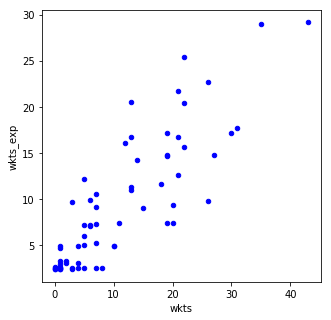

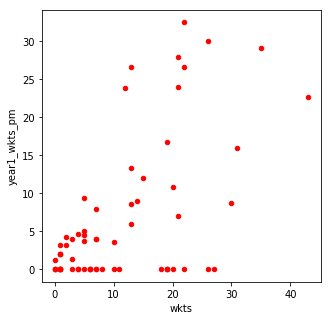

In [98]:
bowling_2011_by_player.plot(kind='scatter',x='wkts',y='wkts_exp',figsize=(5,5),c='b')
bowling_2011_by_player.plot(kind='scatter',x='wkts',y='year1_wkts_pm',figsize=(5,5),c='r')
plt.show()

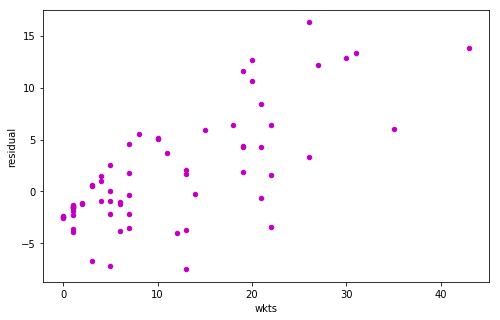

In [114]:
bowling_2011_by_player['residual'] = bowling_2011_by_player.wkts - bowling_2011_by_player.wkts_exp
#bowling_2011_by_player[['wkts','residual']].plot(figsize=(12,7))
df_sorted = bowling_2011_by_player.sort_values(['wkts','residual'])
#plt.plot(df_sorted.wkts,df_sorted.residual)
df_sorted.plot(kind='scatter',x='wkts',y='residual',figsize=(8,5),c='m')
plt.show()

In [76]:
df_2005_2011[['year1_wkts_pm','year2_wkts_pm','year3_wkts_pm','year4_wkts_pm','year5_wkts_pm']].head()

,year1_wkts_pm,year2_wkts_pm,year3_wkts_pm,year4_wkts_pm,year5_wkts_pm
273,1.25,1.500,0.000000,0.000000,0.000000
274,2.00,4.625,7.000000,7.000000,2.666667
275,5.80,0.000,5.285714,4.307692,3.750000
276,2.25,3.000,0.000000,0.000000,0.000000
277,0.50,0.000,0.000000,0.000000,0.000000


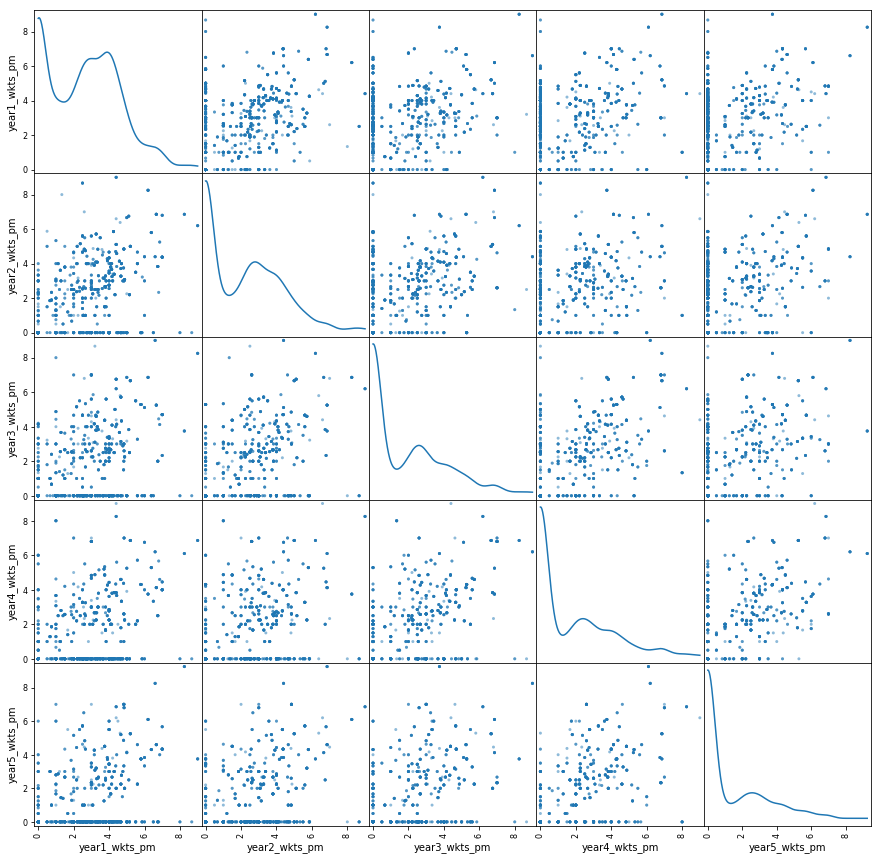

In [79]:
scatter_matrix(df_2005_2011[['year1_wkts_pm','year2_wkts_pm','year3_wkts_pm','year4_wkts_pm','year5_wkts_pm']],
               figsize=(15,15), diagonal='kde')
plt.show()

In [81]:
df_2005_2011[['year1_wkts_pm','year2_wkts_pm','year3_wkts_pm','year4_wkts_pm','year5_wkts_pm']].corr()

,year1_wkts_pm,year2_wkts_pm,year3_wkts_pm,year4_wkts_pm,year5_wkts_pm
year1_wkts_pm,1.000000,0.528595,0.458705,0.445140,0.450574
year2_wkts_pm,0.528595,1.000000,0.544589,0.482486,0.503695
year3_wkts_pm,0.458705,0.544589,1.000000,0.666682,0.570349
year4_wkts_pm,0.445140,0.482486,0.666682,1.000000,0.684669
year5_wkts_pm,0.450574,0.503695,0.570349,0.684669,1.000000


In [135]:
X_train = df[mask_2005_2010][features]
X_test = df[mask_2011][features]
y_train = df[mask_2005_2010][target]
y_test = df[mask_2011][target]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1557, 14), (219, 14), (1557,), (219,))

In [136]:
lin_mod = sm.OLS(y_train, sm.add_constant(X_train))
fit_lin = lin_mod.fit()
print(fit_lin.summary())

                            OLS Regression Results                            
Dep. Variable:                   wkts   R-squared:                       0.103
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     12.63
Date:                Tue, 09 Jan 2018   Prob (F-statistic):           1.71e-28
Time:                        15:06:36   Log-Likelihood:                -3491.1
No. Observations:                1557   AIC:                             7012.
Df Residuals:                    1542   BIC:                             7093.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.6096    

In [137]:
y_pred_train = fit_lin.predict(sm.add_constant(X_train))
y_pred_test = fit_lin.predict(sm.add_constant(X_test))
y_pred_train.shape, y_pred_test.shape, y_train.shape, y_test.shape

((1557,), (219,), (1557,), (219,))

In [138]:
r2_score(y_train,y_pred_train), r2_score(y_test,y_pred_test)

(0.10286682228128463, -0.08869253340839145)

In [142]:
X_train = df[mask_2005_2010][features_small]
X_test = df[mask_2011][features_small]
y_train = df[mask_2005_2010][target]
y_test = df[mask_2011][target]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1557, 9), (219, 9), (1557,), (219,))

In [143]:
lin_mod = sm.OLS(y_train, sm.add_constant(X_train))
fit_lin = lin_mod.fit()
print(fit_lin.summary())

                            OLS Regression Results                            
Dep. Variable:                   wkts   R-squared:                       0.087
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     16.48
Date:                Tue, 09 Jan 2018   Prob (F-statistic):           4.08e-26
Time:                        15:16:31   Log-Likelihood:                -3504.4
No. Observations:                1557   AIC:                             7029.
Df Residuals:                    1547   BIC:                             7082.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                   1.1044    

In [144]:
y_pred_train = fit_lin.predict(sm.add_constant(X_train))
y_pred_test = fit_lin.predict(sm.add_constant(X_test))
y_pred_train.shape, y_pred_test.shape, y_train.shape, y_test.shape

((1557,), (219,), (1557,), (219,))

In [145]:
r2_score(y_train,y_pred_train), r2_score(y_test,y_pred_test)

(0.087487762598352226, -0.052339768721938462)

In [157]:
X_train = df[mask_2005_2010][features_smaller]
X_test = df[mask_2011][features_smaller]
y_train = df[mask_2005_2010][target]
y_test = df[mask_2011][target]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1557, 7), (219, 7), (1557,), (219,))

In [158]:
lin_mod = sm.OLS(y_train, sm.add_constant(X_train))
fit_lin = lin_mod.fit()
print(fit_lin.summary())

                            OLS Regression Results                            
Dep. Variable:                   wkts   R-squared:                       0.086
Model:                            OLS   Adj. R-squared:                  0.082
Method:                 Least Squares   F-statistic:                     20.94
Date:                Tue, 09 Jan 2018   Prob (F-statistic):           4.45e-27
Time:                        15:40:48   Log-Likelihood:                -3505.3
No. Observations:                1557   AIC:                             7027.
Df Residuals:                    1549   BIC:                             7069.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const               1.4265      0.429     

In [159]:
y_pred_train = fit_lin.predict(sm.add_constant(X_train))
y_pred_test = fit_lin.predict(sm.add_constant(X_test))
y_pred_train.shape, y_pred_test.shape, y_train.shape, y_test.shape

((1557,), (219,), (1557,), (219,))

In [165]:
y_pred_test.head()

2928    2.537028
2929    3.182161
2930    3.368830
2931    2.780084
2932    2.077976
dtype: float64

In [162]:
r2_score(y_train,y_pred_train), r2_score(y_test,y_pred_test)

(0.086447534350594823, -0.050230058416655066)

In [163]:
type(y_pred_test), type(pd.DataFrame(y_pred_test)), pd.DataFrame(y_pred_test).shape

(pandas.core.series.Series, pandas.core.frame.DataFrame, (219, 1))

In [167]:
pd.DataFrame(y_pred_test).head()

,0
2928,2.537028
2929,3.182161
2930,3.368830
2931,2.780084
2932,2.077976


In [169]:
bowling_2011 = pd.concat([df[mask_2011][['player','wkts','year1_wkts_pm']].reset_index(),pd.DataFrame(y_pred_test).reset_index()],axis=1,)
bowling_2011.head()

,index,player,wkts,year1_wkts_pm,index,0
0,2928,SK Raina,1,1.500000,2928,2.537028
1,2929,A Mishra,3,2.666667,2929,3.182161
2,2930,GP Swann,2,3.333333,2930,3.368830
3,2931,I Sharma,1,1.888889,2931,2.780084
4,2932,P Kumar,2,0.000000,2932,2.077976


In [170]:
bowling_2011 = bowling_2011.drop('index',axis=1)
bowling_2011.columns = ['player','wkts','year1_wkts_pm','wkts_exp']
bowling_2011.head(10)

,player,wkts,year1_wkts_pm,wkts_exp
0,SK Raina,1,1.500000,2.537028
1,A Mishra,3,2.666667,3.182161
2,GP Swann,2,3.333333,3.368830
3,I Sharma,1,1.888889,2.780084
4,P Kumar,2,0.000000,2.077976
5,S Sreesanth,0,2.166667,2.962108
6,SCJ Broad,6,1.250000,2.783411
7,JM Anderson,6,4.166667,3.747603
8,TT Bresnan,5,6.000000,3.500865
9,D Bishoo,3,0.000000,2.110320


In [171]:
bowling_2011_by_player = bowling_2011.groupby('player').sum()
bowling_2011_by_player.shape

(65, 3)

In [172]:
bowling_2011_by_player.head(10)

,wkts,year1_wkts_pm,wkts_exp
player,,,
A Mishra,7,8.000000,9.366627
A Mithun,3,1.333333,2.408382
BAW Mendis,1,3.200000,3.496384
BW Hilfenhaus,10,3.600000,5.191808
CRD Fernando,7,4.000000,9.570390
CS Martin,7,4.000000,6.126366
CT Tremlett,22,32.500000,19.211453
D Bishoo,19,0.000000,12.933797
DAJ Bracewell,10,0.000000,4.178020


In [174]:
print('model r2 score: ' + str(r2_score(bowling_2011_by_player.wkts,bowling_2011_by_player.wkts_exp)))
print('baseln r2 score: ' + str(r2_score(bowling_2011_by_player.wkts,bowling_2011_by_player.year1_wkts_pm)))

model r2 score: 0.653260646097
baseln r2 score: 0.0105943769725


In [175]:
print('model exp var: ' + str(explained_variance_score(bowling_2011_by_player.wkts,bowling_2011_by_player.wkts_exp)))
print('baseln exp var: ' + str(explained_variance_score(bowling_2011_by_player.wkts,bowling_2011_by_player.year1_wkts_pm)))

model exp var: 0.682772951849
baseln exp var: 0.229112985258


In [176]:
print('model mse: ' + str(mean_squared_error(bowling_2011_by_player.wkts,bowling_2011_by_player.wkts_exp)))
print('baseln mse: ' + str(mean_squared_error(bowling_2011_by_player.wkts,bowling_2011_by_player.year1_wkts_pm)))

model mse: 34.5056949937
baseln mse: 98.4604956691


## 20006-2011 for training and 2012 for testing

In [177]:
mask_2006_2011 = (df.year >= 2006) & (df.year <= 2011)
mask_2012 = (df.year == 2012)

In [178]:
len(mask_2006_2011), type(mask_2006_2011), len(mask_2012), type(mask_2012)

(4742, pandas.core.series.Series, 4742, pandas.core.series.Series)

In [179]:
mask_2006_2011.value_counts()

False    3218
True     1524
Name: year, dtype: int64

In [180]:
X_train = df[mask_2006_2011][features]
X_test = df[mask_2012][features]
y_train = df[mask_2006_2011][target]
y_test = df[mask_2012][target]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1524, 14), (296, 14), (1524,), (296,))

In [181]:
random_forest_grid = {'max_depth': [3, None],
                      'max_features': ['sqrt', 'log2', 5, None],
                      'min_samples_split': [2, 4],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [100,300,500],
                      'random_state': [10]}

rf_gridsearch = GridSearchCV(RandomForestRegressor(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='r2')
rf_gridsearch.fit(X_train, y_train)

print("best parameters:", rf_gridsearch.best_params_)

best_rf_model = rf_gridsearch.best_estimator_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    8.9s
[Parallel(n_jobs=-1)]: Done 260 tasks      | elapsed:   39.5s
[Parallel(n_jobs=-1)]: Done 510 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  3.7min finished


best parameters: {'bootstrap': True, 'max_depth': 3, 'max_features': None, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300, 'random_state': 10}


In [182]:
best_rf_model.score(X_train,y_train), best_rf_model.score(X_test,y_test)

(0.13104996121932921, 0.030952864137245295)

In [183]:
feature_importance = {}
for label, importance in zip(X_train.columns, best_rf_model.feature_importances_):
    feature_importance[label] = importance

#feature_importance
sorted(feature_importance.items(), key=lambda x: (-x[1]))

[('year1_wkts_pm', 0.38781703140398771),
 ('year2_wkts_pm', 0.19023045507808475),
 ('year3_wkts_pm', 0.12499414363595472),
 ('year4_wkts_pm', 0.059929921967871669),
 ('ground_bowl_typ', 0.055231466346554681),
 ('oppo_agnst_bowl_typ', 0.037468032446783851),
 ('bowler_agnst_oppo', 0.033563832476684291),
 ('year1_mtchs_pld', 0.029310578793243867),
 ('bowl_home_adv', 0.023648233634919559),
 ('year3_mtchs_pld', 0.018536402978078959),
 ('year5_mtchs_pld', 0.012691846239699585),
 ('year2_mtchs_pld', 0.01020957844760528),
 ('year5_wkts_pm', 0.010149704652586317),
 ('year4_mtchs_pld', 0.0062187718979445517)]

[ 0.38781703  0.19023046  0.12499414  0.05992992  0.05523147  0.03746803
  0.03356383  0.02931058  0.02364823  0.0185364   0.01269185  0.01020958
  0.0101497   0.00621877]


(-1, 14)

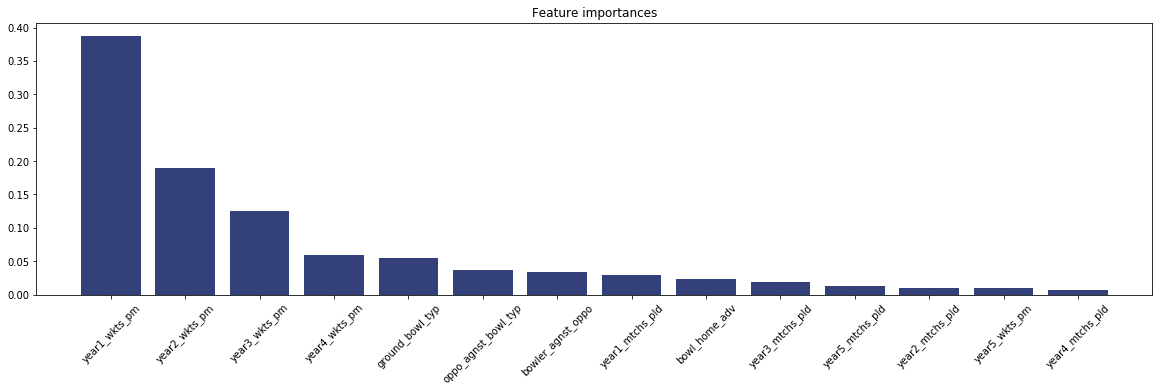

In [184]:
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = list(X_train.columns[indices])
print (importances[indices])
plt.figure(figsize=(20,5))
plt.title("Feature importances")
plt.bar(range(14), importances[indices], color="#334079", align="center")
# #664079
plt.xticks(range(14), feature_names,rotation='45')
plt.xlim([-1, 14])

In [220]:
features_small = ['year1_wkts_pm','year2_wkts_pm', 'year3_wkts_pm', 'year4_wkts_pm','year5_wkts_pm',
                  'bowler_agnst_oppo','oppo_agnst_bowl_typ', 'bowl_home_adv', 'ground_bowl_typ']

In [221]:
X_train = df[mask_2006_2011][features_small]
X_test = df[mask_2012][features_small]
y_train = df[mask_2006_2011][target]
y_test = df[mask_2012][target]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1524, 9), (296, 9), (1524,), (296,))

In [222]:
random_forest_grid = {'max_depth': [3, None],
                      'max_features': ['sqrt', 'log2', 3, None],
                      'min_samples_split': [2, 4],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [100,300,500],
                      'random_state': [10]}

In [223]:
rf_gridsearch = GridSearchCV(RandomForestRegressor(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='r2')
rf_gridsearch.fit(X_train, y_train)

print("best parameters:", rf_gridsearch.best_params_)

best_rf_model = rf_gridsearch.best_estimator_

Fitting 3 folds for each of 288 candidates, totalling 864 fits


[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 215 tasks      | elapsed:   30.6s
[Parallel(n_jobs=-1)]: Done 465 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 815 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 864 out of 864 | elapsed:  3.5min finished


best parameters: {'bootstrap': False, 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100, 'random_state': 10}


In [224]:
best_rf_model.score(X_train,y_train), best_rf_model.score(X_test,y_test)

(0.12177280201099006, 0.038895453049400008)

In [225]:
feature_importance = {}
for label, importance in zip(X_train.columns, best_rf_model.feature_importances_):
    feature_importance[label] = importance

#feature_importance
sorted(feature_importance.items(), key=lambda x: (-x[1]))

[('year1_wkts_pm', 0.33370269707437977),
 ('year2_wkts_pm', 0.20421979491958545),
 ('year3_wkts_pm', 0.19412196020490124),
 ('year4_wkts_pm', 0.1021181496544126),
 ('year5_wkts_pm', 0.066365530585402815),
 ('bowler_agnst_oppo', 0.042244816872319929),
 ('ground_bowl_typ', 0.030365554182365289),
 ('oppo_agnst_bowl_typ', 0.017775095188454524),
 ('bowl_home_adv', 0.0090864013181783301)]

[ 0.3337027   0.20421979  0.19412196  0.10211815  0.06636553  0.04224482
  0.03036555  0.0177751   0.0090864 ]


(-1, 9)

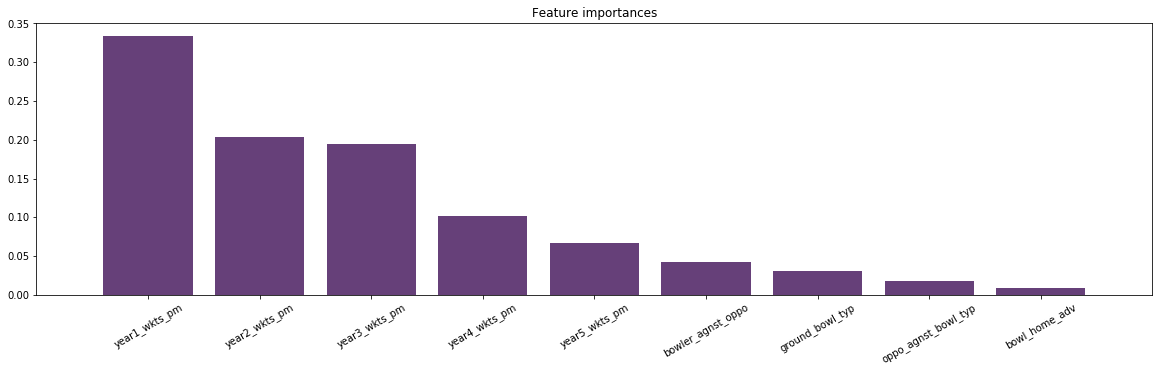

In [226]:
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = list(X_train.columns[indices])
print (importances[indices])
plt.figure(figsize=(20,5))
plt.title("Feature importances")
plt.bar(range(9), importances[indices], color="#664079", align="center")
# #664079
plt.xticks(range(9), feature_names,rotation='30')
plt.xlim([-1, 9])

In [227]:
y_test_pred = best_rf_model.predict(X_test)
type(y_test_pred)

numpy.ndarray

In [228]:
df[mask_2012][['player','wkts']].shape, pd.DataFrame(y_test_pred).shape

((296, 2), (296, 1))

In [229]:
bowling_2012 = pd.concat([df[mask_2012][['player','wkts']].reset_index(),pd.DataFrame(y_test_pred).reset_index()],axis=1,)

In [230]:
bowling_2012.head()

,index,player,wkts,index,0
0,3147,Imran Tahir,0,0,2.447258
1,3148,R Ashwin,5,1,3.287970
2,3149,V Sehwag,0,2,2.508820
3,3150,NM Lyon,5,3,3.145197
4,3151,MJ Clarke,0,4,2.511786


In [231]:
bowling_2012 = bowling_2012.drop('index',axis=1)
bowling_2012.columns = ['player','wkts','wkts_exp']
bowling_2012.head(10)

,player,wkts,wkts_exp
0,Imran Tahir,0,2.447258
1,R Ashwin,5,3.287970
2,V Sehwag,0,2.508820
3,NM Lyon,5,3.145197
4,MJ Clarke,0,2.511786
5,NM Lyon,5,3.278927
6,Z Khan,3,3.521909
7,I Sharma,0,3.217088
8,DW Steyn,4,3.994102
9,RK Kleinveldt,4,2.663318


In [233]:
bowling_2012_by_player = bowling_2012.groupby('player').sum()
bowling_2012_by_player.shape

(73, 2)

In [234]:
bowling_2012_by_player.describe()

,wkts,wkts_exp
count,73.000000,73.000000
mean,12.465753,12.289265
std,13.076784,10.089260
min,0.000000,2.465456
25%,2.000000,4.478431
50%,8.000000,9.874806
75%,18.000000,17.177575
max,44.000000,40.100799


In [236]:
r2_score(bowling_2012_by_player.wkts,bowling_2012_by_player.wkts_exp)

0.75262643741815816

In [237]:
explained_variance_score(bowling_2012_by_player.wkts,bowling_2012_by_player.wkts_exp)

0.7528111180247693

In [238]:
mean_squared_error(bowling_2012_by_player.wkts,bowling_2012_by_player.wkts_exp)

41.721972145957679

In [239]:
features_smaller = ['year1_wkts_pm','year2_wkts_pm', 'year3_wkts_pm', 'year4_wkts_pm','year5_wkts_pm',
                    'bowl_home_adv', 'ground_bowl_typ']

In [240]:
X_train = df[mask_2006_2011][features_smaller]
X_test = df[mask_2012][features_smaller]
y_train = df[mask_2006_2011][target]
y_test = df[mask_2012][target]
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((1524, 7), (296, 7), (1524,), (296,))

In [243]:
random_forest_grid = {'max_depth': [3, None],
                      'max_features': ['sqrt', 'log2', 2, 3, None],
                      'min_samples_split': [2, 4],
                      'min_samples_leaf': [1, 2, 4],
                      'bootstrap': [True, False],
                      'n_estimators': [100,300,500],
                      'random_state': [10]}

In [244]:
rf_gridsearch = GridSearchCV(RandomForestRegressor(),
                             random_forest_grid,
                             n_jobs=-1,
                             verbose=True,
                             scoring='r2')
rf_gridsearch.fit(X_train, y_train)

print("best parameters:", rf_gridsearch.best_params_)

best_rf_model = rf_gridsearch.best_estimator_

Fitting 3 folds for each of 360 candidates, totalling 1080 fits


[Parallel(n_jobs=-1)]: Done  76 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 251 tasks      | elapsed:   33.6s
[Parallel(n_jobs=-1)]: Done 501 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 851 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 1080 out of 1080 | elapsed:  3.5min finished


best parameters: {'bootstrap': True, 'max_depth': 3, 'max_features': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 300, 'random_state': 10}


In [245]:
best_rf_model.score(X_train,y_train), best_rf_model.score(X_test,y_test)

(0.12119560931544426, 0.036062681816493858)

In [246]:
feature_importance = {}
for label, importance in zip(X_train.columns, best_rf_model.feature_importances_):
    feature_importance[label] = importance

#feature_importance
sorted(feature_importance.items(), key=lambda x: (-x[1]))

[('year1_wkts_pm', 0.30662171993767584),
 ('year2_wkts_pm', 0.21834042989794536),
 ('year3_wkts_pm', 0.18471798510079979),
 ('year4_wkts_pm', 0.12532894300001551),
 ('year5_wkts_pm', 0.064315560039681655),
 ('ground_bowl_typ', 0.062070833592655188),
 ('bowl_home_adv', 0.038604528431227005)]

[ 0.30662172  0.21834043  0.18471799  0.12532894  0.06431556  0.06207083
  0.03860453]


(-1, 7)

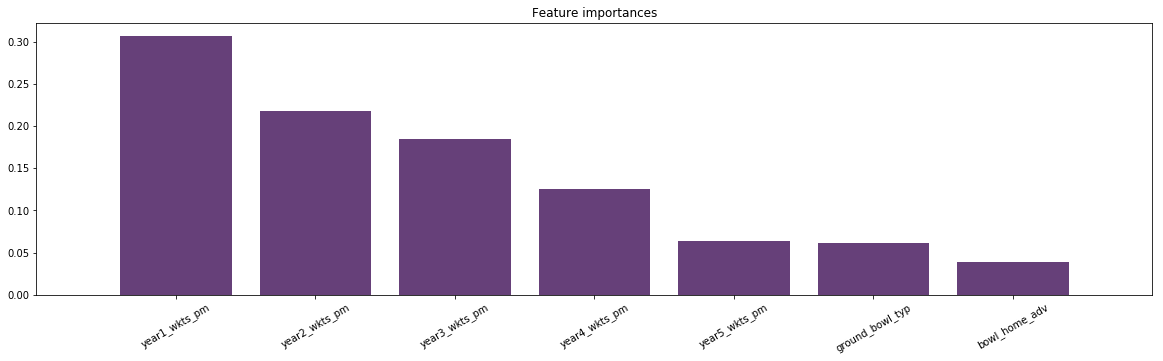

In [247]:
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = list(X_train.columns[indices])
print (importances[indices])
plt.figure(figsize=(20,5))
plt.title("Feature importances")
plt.bar(range(7), importances[indices], color="#664079", align="center")
# #664079
plt.xticks(range(7), feature_names,rotation='30')
plt.xlim([-1, 7])

In [248]:
y_test_pred = best_rf_model.predict(X_test)
type(y_test_pred), type(pd.DataFrame(y_test_pred)), pd.DataFrame(y_test_pred).shape

(numpy.ndarray, pandas.core.frame.DataFrame, (296, 1))

In [249]:
bowling_2012 = pd.concat([df[mask_2012][['player','wkts','year1_wkts_pm']].reset_index(),pd.DataFrame(y_test_pred)],axis=1,)
bowling_2012.head()

,index,player,wkts,year1_wkts_pm,0
0,3147,Imran Tahir,0,2.333333,2.588625
1,3148,R Ashwin,5,6.500000,3.286985
2,3149,V Sehwag,0,0.000000,2.476217
3,3150,NM Lyon,5,3.166667,3.150806
4,3151,MJ Clarke,0,0.000000,2.465414


In [250]:
bowling_2012 = bowling_2012.drop('index',axis=1)
bowling_2012.columns = ['player','wkts','year1_wkts_pm','wkts_exp']
bowling_2012.head(10)

,player,wkts,year1_wkts_pm,wkts_exp
0,Imran Tahir,0,2.333333,2.588625
1,R Ashwin,5,6.500000,3.286985
2,V Sehwag,0,0.000000,2.476217
3,NM Lyon,5,3.166667,3.150806
4,MJ Clarke,0,0.000000,2.465414
5,NM Lyon,5,3.166667,3.150806
6,Z Khan,3,4.333333,3.548263
7,I Sharma,0,3.583333,3.207637
8,DW Steyn,4,5.200000,4.185417
9,RK Kleinveldt,4,0.000000,2.627015


In [251]:
bowling_2012_by_player = bowling_2012.groupby('player').sum()
bowling_2012_by_player.shape

(73, 3)

In [252]:
bowling_2012_by_player.head(10)

,wkts,year1_wkts_pm,wkts_exp
player,,,
AD Mathews,2,0.000000,9.876343
BW Hilfenhaus,35,45.000000,28.576107
CS Martin,12,17.500000,15.830796
D Bishoo,1,3.166667,3.117314
DA Warner,2,0.000000,2.628634
DAJ Bracewell,18,45.000000,28.740865
DJG Sammy,10,15.166667,17.584214
DL Vettori,3,8.000000,11.232041
DW Steyn,38,52.000000,41.854317


In [253]:
print('model r2 score: ' + str(r2_score(bowling_2012_by_player.wkts,bowling_2012_by_player.wkts_exp)))
print('baseln r2 score: ' + str(r2_score(bowling_2012_by_player.wkts,bowling_2012_by_player.year1_wkts_pm)))

model r2 score: 0.746390724032
baseln r2 score: 0.436717666191


In [254]:
print('model exp var: ' + str(explained_variance_score(bowling_2012_by_player.wkts,bowling_2012_by_player.wkts_exp)))
print('baseln exp var: ' + str(explained_variance_score(bowling_2012_by_player.wkts,bowling_2012_by_player.year1_wkts_pm)))

model exp var: 0.746524856398
baseln exp var: 0.436756427391


In [255]:
print('model mse: ' + str(mean_squared_error(bowling_2012_by_player.wkts,bowling_2012_by_player.wkts_exp)))
print('baseln mse: ' + str(mean_squared_error(bowling_2012_by_player.wkts,bowling_2012_by_player.year1_wkts_pm)))

model mse: 42.7736862318
baseln mse: 95.0030779207


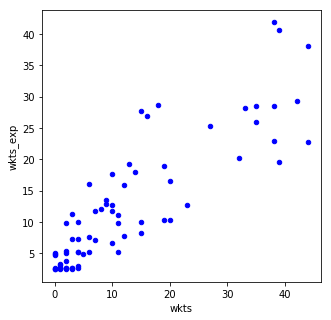

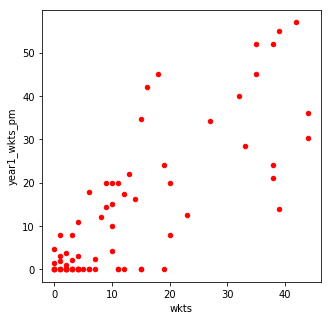

In [256]:
bowling_2012_by_player.plot(kind='scatter',x='wkts',y='wkts_exp',figsize=(5,5),c='b')
bowling_2012_by_player.plot(kind='scatter',x='wkts',y='year1_wkts_pm',figsize=(5,5),c='r')
plt.show()

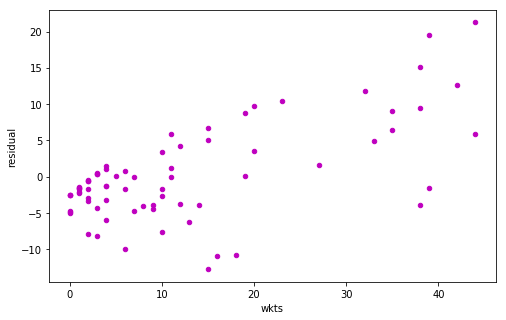

In [257]:
bowling_2012_by_player['residual'] = bowling_2012_by_player.wkts - bowling_2012_by_player.wkts_exp
df_sorted = bowling_2012_by_player.sort_values(['wkts','residual'])
df_sorted.plot(kind='scatter',x='wkts',y='residual',figsize=(8,5),c='m')
plt.show()